# Day 1: Introduction to Machine Learning for Sentiment Analysis

Today we will learn to build a very simple sentiment predictor, which will allow us to forecast the rating of short product reviews on a scale from very positive (5 stars) to very negative (1 star), based on the content of the text only: we will pretend that we can only see the text, and try if we can predict how many stars the user gave the product based on its tone. This is a useful exercise for situations in which we don't have a "star rating" easily available. For example, if we are running our own business, many users will probably write tweets or Facebook posts in which they state their opinion of the business, and we want to be able to quickly sort the good from the bad reviews.

For this project, we start by setting up our Python environment, and downloading a couple of example datasets (Amazon product reviews) from the Internet. These data were collected by Julian McAuley, UCSD (http://jmcauley.ucsd.edu/data/amazon/).


In [1]:
%matplotlib inline
datadir = './data/'

import urllib.request, os, gzip

def download_data(dataset_name, datadir):
    filename = 'reviews_%s_5.json' % dataset_name
    filepath = os.path.join(datadir, filename)
    if os.path.exists(filepath):
        print("Dataset %s has already been downloaded to %s" % (dataset_name, datadir))
    else:
        url = 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/%s.gz' % filename
        urllib.request.urlretrieve(url, filepath + ".gz")
        with gzip.open(filepath + ".gz", 'rb') as fin:
            with open(filepath, 'wb') as fout:
                fout.write(fin.read())
        print("Downloaded dataset %s and saved it to %s" % (dataset_name, datadir))

dataset = "Baby"
download_data(dataset, datadir)


Dataset Baby has already been downloaded to ./data/


The data we use have been stored in the JSON format, which is a standard format for exchanging data over the Internet. The "JS" stands for JavaScript, which we'll learn about in week 5 of the summer of code! But Python allows us to read these data using the json library:

In [2]:
import json

def load_data(dataset_name, datadir):
    filepath = os.path.join(datadir, 'reviews_%s_5.json' % dataset_name)
    if not os.path.exists(filepath):
        download_data(dataset_name, datadir)
    data = []
    with open(filepath, 'r') as f:
        for line in f:                            # read file line by line
            item_hash = hash(line)                # we will use this later for partitioning our data 
            item = json.loads(line)               # convert JSON string to Python dict
            item['hash'] = item_hash              # add hash for identification purposes
            data.append(item)
    print("Loaded %d data for dataset %s" % (len(data), dataset_name))
    return data

# load the data...
baby = load_data(dataset, datadir)
# ... and have a look at an example item (item number 9426):
print(baby[9426])
#for i, l in enumerate(baby):
#    if l['overall'] == 5.0 and 'horrible' in l['reviewText'] and 'bad' in l['reviewText'] and l['helpful'][0]>0:
#        print(i, l['reviewText'])

Loaded 160792 data for dataset Baby
{'reviewerName': 'Erin White "Erin"', 'reviewTime': '05 20, 2005', 'overall': 5.0, 'hash': -6319293282622464590, 'summary': 'Has more comforts than Medela!', 'asin': 'B0000TYHD2', 'reviewerID': 'A2H4QWDVXARPAU', 'reviewText': "I bought this pump for my new baby because it just as others below have said it looks more comfortable than others and it is! Including Medela. With my other child I encountered breastfeeding problems and had a horrible cheap pump. Now with my new baby she was born with a heart problem (she is fine now after a long road to recovery) and had to stay in the hospital for an extended length of time. Meanwhile I had other children at home and we live 6 hours away from our family and so I had no choice but to divide my time between the hospital and home, which meant I needed a hospital grade pump originally I rented one from the hospital (Medela) and it made my breasts hurt really bad. On the way home from the hospital I stopped in a

We see that the dataset contains 160792 data items, with 9 fields called `reviewTime, asin, reviewerID, reviewText, unixReviewTime, summary, helpful, reviewerName, overall`. For example, this particular review was written on May 20, 2005, by the user 'Erin White "Erin"'. Erin summarized the product as "Has more comforts than Medela!" and gave it 5 stars (out of 5). 7 out of 8 other users rated this review helpful. We also added a hash, which is a single number summarizing the whole data item. For now we can view it as a random ID that is (extremely likely to be) unique for each data item, a bit like a US social security number.

For this project, we will ignore all fields except reviewText and overall (i.e. the overall rating in stars out of five). The idea is to find out if we can infer the star rating (how much the user liked the product) by only looking at the text. This way we can learn how to automatically analyze even texts that come without a star rating, such as Facebook posts or tweets.

Before we start building a complicated AI solution, it is good practice to first implement a very simple "baseline predictor" and measure its performance. This way we get a feeling how hard (or easy) the problem is, For example, we can check for the presence of certain words with strong positive or negative connotations, such as "good" or "fantastic" versus "bad" or "poor". Note that this review contains the words "horrible", "hurt", "bad" and "problem", and still received 5 stars. This gives us already a feeling for the difficulty of the sentiment analysis problem.

Before we develop our first sentiment predictor, we need to partition our data into a training set, a validation set, and a test set. This is something we should do in all our machine learning projects. The idea is that our predictor might overgeneralize from the examples we show it if we are not careful. This is a bit like a child whom you have shown how an iPad works, and then they try to swipe everything that looks like a screen (the TV, the microwave etc.)

For instance, the example review listed above might be the only review with the phrase "6 hours" in it, and our predictor might learn a rule that the phrase "6 hours" is indicative of a high star rating. Such a rule would be unlikely to generalize well to new reviews that we didn't show to the predictor while it was training. So after training our predictor (using only examples from the training set), we need to be able to measure its performance on reviews it hasn't seen yet, which is what the test set is for. We use the validation set because we may want to explore different predictor variants and get an idea how well they perform on unseen examples before committing to one.

Therefore the general procedure when developing a predictor using machine learning is as follows:

Train several variants of a predictor using examples from the training set only.
Use the predictor performance on the validation set to select a single best predictor among all the possible variants. This step also involves debugging our implementation of the predictor, tweaking its parameters etc.
Use the test set to get an idea how well our best predictor is expected to perform on unseen data. This step should only be performed once, at the very end of the experiment: if we tweak our predictor based on its performance on the test set, we simply may find a variant that "gets lucky" on the test set, and overestimate its accuracy on truly unseen examples.
A common rule of thumb is to use 60% of our data for the training, 20% for validation, and 20% for testing. We could simply take the first 60% of our review data for training, but then we have to assume that the dataset has been "mixed" well in advance. We achieve a better randomization by using the hash we computed from the JSON string and checking its modulus 10:


In [3]:
def partition_train_validation_test(data):
    # 60% : modulus is 0, 1, 2, 3, 4, or 5
    data_train = [item for item in data if item['hash']%10<=5]  
    # 20% : modulus is 6 or 7
    data_valid = [item for item in data if item['hash']%10 in [6,7]] 
    # 20% : modulus is 8 or 9
    data_test  = [item for item in data if item['hash']%10 in [8,9]] 
    return data_train, data_valid, data_test
    
baby_train, baby_valid, baby_test = partition_train_validation_test(baby)

print("Now we have", len(baby_train), "training examples,", len(baby_valid),
      "validation examples, and", len(baby_test), "test examples")

Now we have 96690 training examples, 31912 validation examples, and 32190 test examples


Prediction algorithms generally work with numbers instead of text. Therefore we need to preprocess our text by extracting from it numeric "features" that we can afterwards feed into our predictor. For our simple baseline predictor, we will use only two features: the frequency of positive words in the review ("good", "great", "like") and the frequency of negative words in the review ("bad", "horrible", "dislike"). Let's call these two features **fpos** and **fneg**. Our hypothesis is that reviews with many positive words (high fpos) are likely to receive 4 or 5 stars, while reviews with many negative words (high fneg) will probably receive 1 or 2 stars. Since reviews differ in their length, it makes sense to express the frequency of positive and negative words as a fraction of the total number of words in the review. Therefore fpos and fneg will be numbers between 0 and 1.

For example, assume the review text is "This is a good, great, fantastic, amazing, wonderful, super product!". We count six positive words and zero negative words (out of ten words in total), so fpos == 0.6 (6/10) and fneg == 0.0 (0/10). 

On the other hand, the review "This is a bad, atrocious, terrible, dreadful, awful, abysmal product!" will have fpos == 0.0 (0/10) and fneg == 0.6 (6/10). Alternatively we could decide to discount all "stop words": these are extremely common words such as "this", "is" or "a", which are required by the syntax of the English language but don't really carry semantic meaning. If we strip out these three words, we have fpos == 0.857 (6/7) in the first example, and fneg == 0.857 in the second example.

Writing down all positive and negative words in the English language by hand would be a very long and tedious task. Thankfully we don't have to do this ourselves, since it was already done by Hu and Liu (https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html). The Hu-Liu lexicon of positive and negative opinion words is available as part of NLTK:

In [5]:
from nltk.corpus import opinion_lexicon
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

import random
random.seed(1234)
print("Some positive words:", ", ".join(random.sample(positive_words, 10)))
print("Some negative words:", ", ".join(random.sample(negative_words, 10)))

intersection = positive_words & negative_words
print("Words that appear in both sets: " + ", ".join(intersection))

Some positive words: subsidize, enchant, profound, lifesaver, undisputable, restructured, enjoy, compatible, restructuring, solid
Some negative words: asinine, loneliness, moronic, obsessive, insolence, hellion, deviously, glut, flicker, incongruous
Words that appear in both sets: enviously, envious, enviousness


While sentiment labeling of individual words can be subjective, most people would agree with the classification as positive or negative for these examples. Notice that the Hu-Liu lexicon contains different word forms: for example, it contains both adjectives ("wholesome") and adverbs ("harshly"), and verbs appear both in the base form ("blurt") and in inflected forms ("picketing"). It also contains common misspellings ("flicering" instead of "flickering"). This is why we will take the words in the reviews as they are (apart from minor preprocessing steps such as converting from upper-case to lower-case), and won't apply more sophisticated preprocessing techniques such as stemming.

We can now write a function that takes a review text and outputs the number of positive and negative words in the review as a fraction of the total number of words in the review (excluding stop words and punctuation). Note that we have to deal with the special case when the total number of words is zero, which happens if the review text is empty. Otherwise we'll end up dividing by zero, and you'll remember from high school that this is not allowed!

In [7]:
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
eng_stopwords = set(stopwords.words('english'))

def my_tokenize(text):
    # split text into lower-case tokens, removing all-punctuation tokens and stopwords
    tokens = []
    for sentence in sent_tokenize(text):
        tokens.extend(x for x in word_tokenize(sentence.lower()) 
                      if x not in eng_stopwords and any(i.isalpha() for i in x))
    return tokens

def pos_neg_fraction(text):
    tokens = my_tokenize(text)
    count_pos, count_neg = 0, 0
    for t in tokens:
        if t in positive_words:
            count_pos += 1
        if t in negative_words:
            count_neg += 1
    count_all = len(tokens)
    if count_all != 0:
        return count_pos/count_all, count_neg/count_all
    else:
        return 0., 0.
    
pos_example = 'This is a good, great, fantastic, amazing, wonderful, super product!!!'
neg_example = 'This is a bad, atrocious, terrible, dreadful, awful, abysmal product!!!'
print(pos_neg_fraction(pos_example))
print(pos_neg_fraction(neg_example))

(0.8571428571428571, 0.0)
(0.0, 0.8571428571428571)


For our two example sentences, this seems to do what we want. Obviously, real reviews usually don't have such an extreme concentration of positive or negative words. Let's find the reviews in our real-world datasets with the highest fraction of positive and negative words, respectively. When exploring the data, it is generally a good idea to restrict ourselves to the training data only, to avoid "peeking ahead" and designing our algorithm so that it works well for the test examples we see.

For the subsequent analysis, we convert our training data set into a matrix `X_train` with two columns and as many rows as there are examples in the data set. The first column contains the fraction of positive words, while the second column contains the fraction of negative words for each example. numpy.array is the standard way to represent matrices in Python. It provides useful helper functions, such as for finding the maximum in each column.

Note that the following cell may take a few minutes to run:

In [8]:
import numpy

def dataset_to_matrix(data):
    return numpy.array([list(pos_neg_fraction(item['reviewText'])) for item in data])

X_train = dataset_to_matrix(baby_train)
most_pos, most_neg = numpy.argmax(X_train, axis=0)
# print the example with the highest fraction of positive words:
print("We found a fraction of %f %% positive words for example %d" % 
      (100.*X_train[most_pos, 0], most_pos))
print(baby_train[most_pos])
print("We found a fraction of %f %% negative words for example %d" %
      (100.*X_train[most_neg, 1], most_neg))
print(baby_train[most_neg])

We found a fraction of 100.000000 % positive words for example 10461
{'reviewerName': 'S. Broderick "Sondra"', 'reviewTime': '07 7, 2014', 'overall': 5.0, 'hash': 6869298777839970922, 'summary': 'Five Stars', 'asin': 'B000A88JYQ', 'reviewerID': 'A2FPJGVT01TVVQ', 'reviewText': 'work perfect', 'unixReviewTime': 1404691200, 'helpful': [0, 0]}
We found a fraction of 100.000000 % negative words for example 24874
{'reviewerName': 'ABDULLAH AL-FALAH', 'reviewTime': '07 4, 2014', 'overall': 2.0, 'hash': 913708519795079022, 'summary': 'Two Stars', 'asin': 'B000WUD83O', 'reviewerID': 'A1SLEYD29KEUW1', 'reviewText': 'too noisy', 'unixReviewTime': 1404432000, 'helpful': [0, 0]}


We see that there actually is an example with 100% positive words (excluding stopwords), which received 5 stars, and also an example with 100% negative words, which received 1 star. Our idea of counting positive and negative words seems promising! We are now almost ready to train our first predictor. The only thing left to do is to collect the numbers we want to predict (the star ratings which are called `overall` in the JSON data), and put them into another NumPy array. We'll call this one **Y_train**.

In machine learning parlance, the matrix **X_train** is called the feature matrix (what we already know) and the matrix **Y_train** is called the target vector (what we want to predict based on the features). You may remember from high-school algebra that vectors are one-dimensional while matrices are two-dimensional. This is because for every example we may have multiple features, but usually a single target. In this case we have two features (fractions of positive and negative examples), so our feature matrix has two columns.

Generally, most machine learning algorithms prefer dealing with numbers (matrices) - so we have to find a way to extract numerical information from non-numerical data such as text. This is exactly what we did when counting the fraction of positive and negative words.

In [9]:
def dataset_to_targets(data):
    return numpy.array([item['overall'] for item in data])

Y_train = dataset_to_targets(baby_train)
print("Our feature matrix is two-dimensional and has shape", X_train.shape)
print("Our target vector is one-dimensional and has shape", Y_train.shape)

Our feature matrix is two-dimensional and has shape (96690, 2)
Our target vector is one-dimensional and has shape (96690,)


In a real machine learning project, now would be a good time to spend more time exploring and visualizing the data. For example, it is a good idea to get a feeling how the features and targets are distributed, as this determines which techniques are a good fit for the problem. The Python community has created a lot of great tools and libraries for exploratory data analysis - unfortunately we don't have the time to discuss them in detail right now.

However, at least we can give you some pointers if you want to study this topic for yourself. We recommend that anyone interested in becoming a data scientist should have a look at the Pandas library. For example, if you want to visualize how many 1-star, 2-star etc. ratings there are in the dataset, you can do it like this:

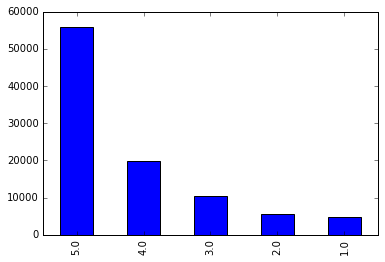

In [11]:
import pandas
pandas.Series(Y_train).value_counts().plot.bar()

We see that 5-star review are by far the most frequent, and very few people leave a 1-star review. We can also visualize the distribution of our features. We see that most reviews don't have negative words at all (sharp peak around 0), while reviews without any positive words are much rarer. The typical review seems to contain around 10% positive words, and around 5% negative words:

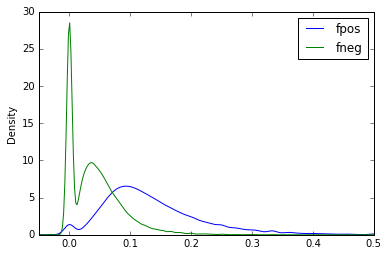

In [13]:
df = pandas.DataFrame(data=X_train, columns = ['fpos', 'fneg'])
df.plot.kde(xlim=(-0.05, 0.5))

These two examples are just meant to whet your appetite. To find out more, have a look at the Pandas documentation (https://pandas.pydata.org/pandas-docs/stable/tutorials.html).

# Predictor

We are now ready to train our first predictor! Generally it's a good idea to keep it simple at the beginning, so we'll start with a method you will probably remember from high school: linear regression (also known as least-squares regression). If you haven't studied the mathematics before or would like to refresh your memory, there are many good materials on the Internet, e.g. on Khanacademy: https://www.khanacademy.org/math/statistics-probability/describing-relationships-quantitative-data Otherwise you can also use the Python libraries as a "black box" - this will be sufficient if you don't plan on working with data a lot.

Later this week we'll learn how to use Google's Tensorflow library to train a linear regression model: however, that will be mostly for pedagogical purposes, and would be a bit of an overkill in practice. The Scikit-learn library (http://scikit-learn.org/stable/) has very good implementations of classical predictors such as linear regression:

In [15]:
from sklearn.linear_model import LinearRegression
lreg = LinearRegression().fit(X_train, Y_train)

print("The coefficient for the fpos variable is", lreg.coef_[0])
print("The coefficient for the fneg variable is", lreg.coef_[1])
print("The intercept is", lreg.intercept_)

The coefficient for the fpos variable is 3.214006165353091
The coefficient for the fneg variable is -5.7424008967444715
The intercept is 4.010060231846752


Just like this, we have trained our first machine learning model! Since linear regression is a very simple predictor, we can actually understand its inner workings quite well. The intercept is the star rating we would expect for a review that contains neither positive nor negative words (fpos==0 and fneg==0): according to the model, such a review should get about 4 stars on average.

If the review contains 20% positive words (fpos==0.2) but still no negative words (fneg==0), we would expect the following rating:

In [16]:
features = [[0.2, 0]]
expected_rating_A = lreg.predict(features)[0]
print("The expected rating is %f stars" % expected_rating_A)
# we can also compute this explicitly:
expected_rating_B = lreg.intercept_ + 0.2*lreg.coef_[0] + 0*lreg.coef_[1]
print("This is the same as %f stars" % expected_rating_B)

The expected rating is 4.652861 stars
This is the same as 4.652861 stars


However, if the review contains no positive words (fpos==0) but 20% negative words (fneg==0.2), we expect the following rating:

In [17]:
features = [[0, 0.2]]
expected_rating_A = lreg.predict(features)[0]
print("The expected rating is %f stars" % expected_rating_A)
# we can also compute this explicitly:
expected_rating_B = lreg.intercept_ + 0 * lreg.coef_[0] + 0.2 * lreg.coef_[1]
print("This is the same as %f stars" % expected_rating_B)

The expected rating is 2.861580 stars
This is the same as 2.861580 stars


We see that the more positive words we have in our review, the higher the expected star rating (the coefficient for the first variable is positive). 

The more negative words there are in the review, however, the lower is the expected star rating (the coefficient for the second variable is negative). This is what we would intuitively expect.

Remember our two examples from earlier, which contained 100% positive words ("so cute") or 100% negative words ("uncomfortable"). For these two extreme examples, we get a very odd prediction

## Intermediate homework for certification:

- calculate the prediction for 100% pos, and 100% neg review
- repeat this same process for "Apps for Android" dataset

Since we haven't told our predictor that all ratings must lie between 1 and 5 stars, it became a bit overenthusiastic in its predictions for these extreme examples. We can simply "cut off" these unrealistic results: if the predicted star rating is above 5 stars, we set it to 5 stars, and if it is below 1 star, we set it to 1 star. Now we have a practical prediction algorithm, which we can apply to our training dataset:

In [19]:
def predict_lreg(features):
    expected_rating = lreg.predict(features)
    expected_rating[expected_rating > 5.0] = 5.0
    expected_rating[expected_rating < 1.0] = 1.0
    return expected_rating

pred_train = predict_lreg(X_train)

Let's look at some random examples first to get a feeling how well this works:

In [20]:
def analyze_training_example(i):
    print("Training example number", i)
    print("True rating = %f stars, expected rating = %f stars" % (Y_train[i], 
                                                                  pred_train[i]))
    print("Features = %f / %f" % (X_train[i,0], X_train[i,1]))
    print("Review text = %s" % baby_train[i]['reviewText'])

for i in [0, 10000, 20000, 30000, 50000]:
    analyze_training_example(i)

Training example number 0
True rating = 5.000000 stars, expected rating = 4.367172 stars
Features = 0.111111 / 0.000000
Review text = Perfect for new parents. We were able to keep track of baby's feeding, sleep and diaper change schedule for the first two and a half months of her life. Made life easier when the doctor would ask questions about habits because we had it all right there!
Training example number 10000
True rating = 5.000000 stars, expected rating = 4.384461 stars
Features = 0.210526 / 0.052632
Review text = After a few months of use I am very happy with this blanket. It is durable and waterproof and folds out easily with one hand. I was concerned about putting it in the washer but have done so a few times on the delicate cycle and it is holding up perfectly.
Training example number 20000
True rating = 1.000000 stars, expected rating = 4.469204 stars
Features = 0.142857 / 0.000000
Review text = Replaced by a bizzilion phone apps.  Would have been awesome in the 90s.
Trainin

Not terrible, but far from perfect either. These few examples already show some of the limitations of our approach. For example, example 50000 is a 1-star review which contains only a single negative word ("hangs"), so the predictor overestimates the rating.

Example 20000 likewise overestimates the rating because it counts words like "top" and "fabulous", which don't refer to the product itself in this example.

Example 30000 is not too far off, but it underestimates the rating because it counts "regret" as a negative word and overlooks the preceding "not". Sophisticated sentiment analyzers need to account for negation: for example, "not bad" should be treated differently from "bad". Intensifiers should also be accounted for: in example 10000, "very disappointed" is stronger than "disappointed", but our predictor doesn't know this.

While looking at individual examples is important and instructive, we need a systematic way to measure the prediction quality across all examples. Scikit-learn provides different evaluation metrics. The conceptually easiest choice is the **mean absolute error**, which counts by how many stars our predictions are off on average (in either direction).

For example, assume we have three examples with true star ratings of 1, 4, 5, and predicted star ratings of 5, 4, 3. Then the first example is off by 4 stars, the second example by 0 stars (predicted and true rating match exactly), and the third example is off by 2 stars. The mean absolute error is therefore (4 + 0 + 2) / 3 = 2.

In [21]:
from sklearn.metrics import mean_absolute_error
mae_train = mean_absolute_error(pred_train, Y_train)
print("The mean absolute error on the training data is %f stars" % mae_train)

The mean absolute error on the training data is 0.832466 stars


So it turns out that we actually aren't that far off, although the accuracy on the validation set is a bit worse than on the training set (which should be expected). Once we move to more complex algorithms, however, we'll have to be very careful not to draw premature conclusions from the training set performance: an algorithm may easily achieve perfect accuracy on the training set, and still completely fail on unseen examples! (Like a student with a photographic memory who can reproduce all the answers to all the math problems she has seen before, but hasn't understood the underlying general theory: so she cannot compute any answer if we change the numbers in the problem slightly).

We don't look at the accuracy on the test set yet, because this is the very last step we should do once we are convinced we have found the best predictor we can think of and want to run one final test. For now, we have established that linear regression with the fraction of positive and negative words as features seems to be a reasonable baseline. Can we do better? Stay tuned!

# Certification

## Beginner - none

## Intermediate 
- calculate the prediction for 100% pos, and 100% neg review, before the cutoff
- repeat this same process for "Apps for Android" dataset

## Advanced
- build a better sentiment analyzer and comment both your code and your data exploration